In [8]:
import math, numpy as np, pandas as pd
import warnings
import scipy.linalg
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import gamma as GAMMA, factorial, beta as BETA
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [9]:
class FDESBase():

    def __init__(self, L, R, T, alpha, beta, gamma, D, h, tau, psi, f, phiL=None, phiR=None):
        self.n = int ((R - L) / h)
        self.k = int (T / tau)
        print(self.n, self.k)
        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau
        self.h = h
        self.L = L
        self.D = D
        self.f = f
        self.phiL = phiL
        self.phiR = phiR
        self.result = np.array([[0.0 for i in range(self.n + 1)] for t in range(self.k + 1)])
        
        for i in range(self.n + 1):
            self.result[0][i] = psi(self.x_i(i))
            
        self.A = np.array([[0.0 for i in range(self.n + 1)] for t in range(self.n + 1)], dtype=np.float64)
        
        self.a = lambda x, t: (1.0 + beta) * (self.D(x, t) / 2.0) * ((tau**gamma)/(h**alpha))
        self.b = lambda x, t: (1.0 - beta) * (self.D(x, t) / 2.0) * ((tau**gamma)/(h**alpha))

    def g(self, a, j):
        return (-1)**j / (a + 1) / BETA(j + 1, a - j +1)
        
    def x_i(self, i):
        return self.L + i * self.h
    
    def t_k(self, k):
        return k * self.tau

    def draw(self, rows, decision = None):
        res = self.result
        colums = 3
        all_count = colums * rows
        step = self.k // (all_count - 1)

        fig, ax = plt.subplots(rows, colums, figsize=(8, 2*rows))
        X = np.array([self.L + self.h*i for i in range(self.n+1)])

        for kk in range(0, all_count):

            TIME = np.array([self.tau*kk*step for i in range(self.n+1)])
            
            if not decision == None:
                ax[kk // colums, kk % colums].plot(X, decision(X, TIME))
            ax[kk // colums, kk % colums].plot(X, res[kk*step], '.-')
            ax[kk // colums, kk % colums].set_title(f"{kk*step} (t = {self.tau*kk*step})")

        plt.show()
        
    def draw2(self, steps, decision = None):
        res = self.result
        
        if isinstance(steps, list):
            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            X = np.array([self.L + self.h*i for i in range(self.n+1)])
        
            for kk in steps:

                TIME = np.array([self.tau*kk for i in range(self.n+1)])

                if not decision == None:
                    ax.plot(X, decision(X, TIME))
                ax.plot(X, res[kk], '.-')
        elif isinstance(steps, int):
            step = self.k // (steps - 1)

            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            X = np.array([self.L + self.h*i for i in range(self.n+1)])
            
            for kk in range(0, steps):

                TIME = np.array([self.tau*kk*step for i in range(self.n+1)])

                if not decision == None:
                    ax.plot(X, decision(X, TIME))
                ax.plot(X, res[kk*step], '.-')

        plt.show()
        
    def delta(self, decision = None):
        if decision == None: 
            return

        res = np.array(self.result)
        time, delt = [], []

        _, _ = plt.subplots(1, 1, figsize=(8, 4))

        X = np.array([self.h*_i for _i in range(self.n+1)])

        for i in range(self.k):
            TIME = np.array([self.tau*i for _i in range(self.n+1)])
            aaa = np.abs(res[i] - decision(X, TIME))

            time.append(self.tau*i)
            delt.append(np.max(aaa))

        plt.plot(time, delt)
        plt.show()
        
    def draw_first_last(self, decision = None):
        res = self.result
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        X = np.array([self.L + self.h*i for i in range(self.n+1)])

        TIME1 = np.array([self.tau*0 for i in range(self.n+1)])
        TIME2 = np.array([self.tau*self.k for i in range(self.n+1)])
        if not decision == None:
            ax.plot(X, decision(X, TIME1))
            ax.plot(X, decision(X, TIME2))
        ax.plot(X, res[0], '.-')
        ax.plot(X, res[-1], '.-')

        plt.show()
        
    def draw3D(self, decision = None):
        XX = np.array([self.x_i(i) for i in range(self.n + 1)])
        TT = np.array([self.t_k(j) for j in range(self.k + 1)])
        XX, TT = np.meshgrid(XX, TT)
        
        if decision != None:
            ZZ = decision(XX, TT)
            fig = plt.figure(figsize=(10,4))
            ax1 = fig.add_subplot(1, 4, 1, projection = "3d")
            ax2 = fig.add_subplot(1, 4, 2, projection = "3d")
            ax3 = fig.add_subplot(1, 4, (3,4))
            ax1.plot_surface(XX, TT, ZZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
            ax1.view_init(40, +30)

            ax2.plot_surface(XX, TT, np.array(self.result), cmap='viridis', linewidth=0, antialiased=False)
            ax2.view_init(40, +30)

            cf = ax3.contourf(XX, TT, np.abs(ZZ - np.array(self.result)), 200, cmap=cm.coolwarm)
            fig.colorbar(cf)
        else:
            fig = plt.figure(figsize=(8,4))
            ax1 = fig.add_subplot(1, 4, (1,2), projection = "3d")
            ax2 = fig.add_subplot(1, 4, (3,4), projection = "3d")
            
            ax1.plot_surface(XX, TT, np.array(self.result), cmap='viridis', linewidth=0, antialiased=False)
            ax1.view_init(40, -30)
            
            ax2.plot_surface(XX, TT, np.array(self.result), cmap='viridis', linewidth=0, antialiased=False)
            ax2.view_init(40, +30)
        
        plt.show()

In [10]:
class MFDES(FDESBase):
    
    def __init__(self, L, R, T, alpha, beta, gamma, D, h, tau, psi, f, phiL=None, phiR=None):
        super().__init__(L, R, T, alpha, beta, gamma, D, h, tau, psi, f, phiL, phiR)
        
    def solve(self):
        
        for t in range(1, self.k + 1):
            
            # Заполняем вектор d
            d = np.array([0.0 for i in range(self.n + 1)])
        
            for i in range(self.n + 1):
                for j in range(1, t + 1):
                    d[i] += self.g(self.gamma, j) * self.result[t-j][i]

                d[i] = d[i] - (self.tau**self.gamma) * self.f(self.x_i(i), self.t_k(t))
            
            # Заполняем матрицу А
            for i in range(self.n + 1):
                for j in range(self.n + 1):
                    if i == j:
                        self.A[i][j] = self.a(self.x_i(i), self.t_k(t)) * self.g(self.alpha, 1.0) + \
                                       self.b(self.x_i(i), self.t_k(t)) * self.g(self.alpha, 1.0) - 1.0
                    elif i + 1 < j:
                        self.A[i][j] = self.b(self.x_i(i), self.t_k(t)) * self.g(self.alpha, j - i + 1.0)
                    elif i > j + 1:
                        self.A[i][j] = self.a(self.x_i(i), self.t_k(t)) * self.g(self.alpha, i - j + 1.0)
                    elif i == j + 1:
                        self.A[i][j] = self.a(self.x_i(i), self.t_k(t)) * self.g(self.alpha, 2.0) + \
                                       self.b(self.x_i(i), self.t_k(t))
                    else:
                        self.A[i][j] = self.a(self.x_i(i), self.t_k(t)) + \
                                       self.b(self.x_i(i), self.t_k(t)) * self.g(self.alpha, 2.0)
            
            # Если есть граничные условия
            if not(self.phiL == None) and not(self.phiR == None):
                d[0] = self.phiL(self.t_k(t))
                d[-1] = self.phiR(self.t_k(t))
                
                for i in range(self.n + 1):
                    self.A[0][i] = 1.0 if i == 0 else 0.0
                    self.A[self.n][i] = 1.0 if i == self.n else 0.0
            
            # Решаем систему
            self.result[t] = scipy.linalg.solve(self.A, d)
            
            # Если есть граничные условия
            if not(self.phiL == None) and not(self.phiR == None):
                self.result[t][0] = self.phiL(self.t_k(t))
                self.result[t][-1] = self.phiR(self.t_k(t)) 
            
            
        return self

In [11]:
class Problem4():

    def __init__(self):
        self.L, self.R = -0.1, 0.1
        self.T = 0.1
        self.alpha = 1.765
        self.gamma = 1.0
        self.h = 0.004
        self.tau = 0.002
        self.beta = 0.0

        self.D = lambda x, t: 0.0005
        self.psi = lambda x: 2.0 * 1.0 if np.abs(x) < self.h else 0.0
        self.f = lambda x, t: 0.0
        self.phiL = None
        self.phiR = None
        self.decision = None

50 50


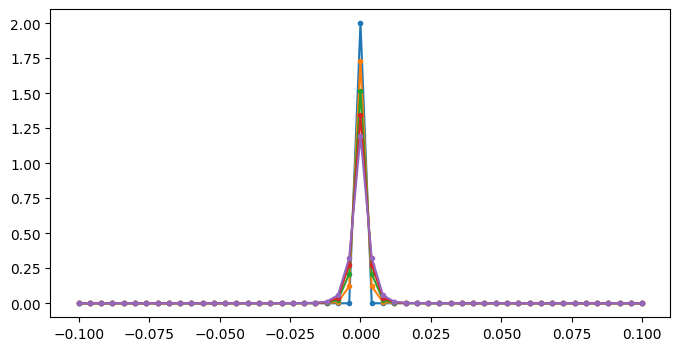

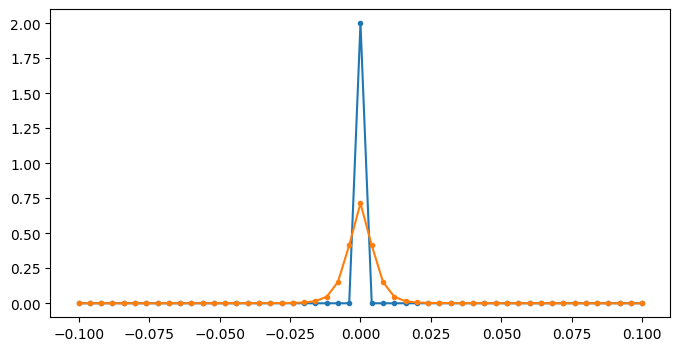

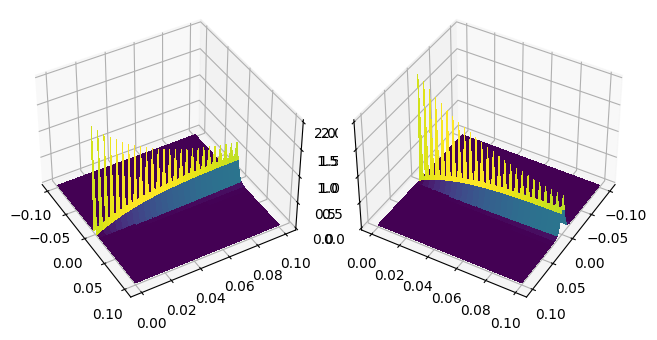

In [12]:
P = Problem4()

mfdes = MFDES(P.L, P.R, P.T, P.alpha, P.beta, P.gamma, P.D, P.h, P.tau, P.psi, P.f, P.phiL, P.phiR).solve()
mfdes.draw2([5*i for i in range(5)], decision = P.decision)
mfdes.draw_first_last(decision = P.decision)
mfdes.draw3D(decision = P.decision)
mfdes.delta(decision = P.decision)

In [13]:
class MonteCarlo(FDESBase):
    
    def __init__(self, L, R, T, alpha, beta, D, h, tau, psi, f = lambda x, t : 0.0, gamma = 1.0, phiL=None, phiR=None):
        super().__init__(L, R, T, alpha, beta, gamma, D, h, tau, psi, f, phiL, phiR)
        self.a = (1.0 + beta) * (D / 2.0) * ((tau**gamma)/(h**alpha))
        self.b = (1.0 - beta) * (D / 2.0) * ((tau**gamma)/(h**alpha))

        probabilities = np.ndarray(2*self.n+2)
        
        probabilities[self.n-1] = (self.a + self.b * self.g(self.alpha, 2.0))
        probabilities[self.n] = 1.0 - self.alpha * (self.a + self.b)
        probabilities[self.n+1] = (self.a * self.g(self.alpha, 2.0) + self.b)
        
        for i in range(2, self.n + 1):
            probabilities[self.n+i] = self.a * self.g(self.alpha, i + 1)
            probabilities[self.n-i] = self.b * self.g(self.alpha, i + 1)
        
        probabilities[-1] = 0.0
        probabilities[-1] = 1.0 - np.sum(probabilities)
        self.result = np.array([[0.0 for i in range(self.n + 1)] for t in range(self.k + 1)])
        self.prefsum_probabilities = np.cumsum(probabilities)
        
        
    def solve(self, count = 10**3):
        from random import uniform
        
        for i in range(count):
            if i % 10000 == 0:
                print(f"[{i}] ....")
            x, y = [self.n // 2, 0]
            self.result[y][x] += 1
            
            for j in range(1, self.k + 1):
                rnd = np.random.uniform(0.0, 1.0)
                
                p = 0
    
                while p < 2*self.n+2 and rnd > self.prefsum_probabilities[p]:
                    p+=1
                
                x -= p - self.n
                    
                if x < 0 or x > self.n:
                    break
                else:
                    self.result[j][x] += 1
        
        return self
    
    def draw(self, rows, count):
        res = np.array(self.result)
        colums = 3
        all_count = colums * rows
        step = self.k // (all_count - 1)

        fig, ax = plt.subplots(rows, colums, figsize=(16, 4*rows), sharex='none', sharey='none')
        X = np.array([self.h*i for i in range(self.n+1)])

        for kk in range(0, all_count):

            TIME = np.array([self.tau*kk*step for i in range(self.n+1)])

            ax[kk // colums, kk % colums].plot(X, res[kk*step] / count, '.-')
            ax[kk // colums, kk % colums].set_title(f"{kk*step} (t = {self.tau*kk*step})")

        plt.show()

50 50
[0] ....
[10000] ....
[20000] ....
[30000] ....
[40000] ....
[50000] ....
[60000] ....
[70000] ....
[80000] ....
[90000] ....


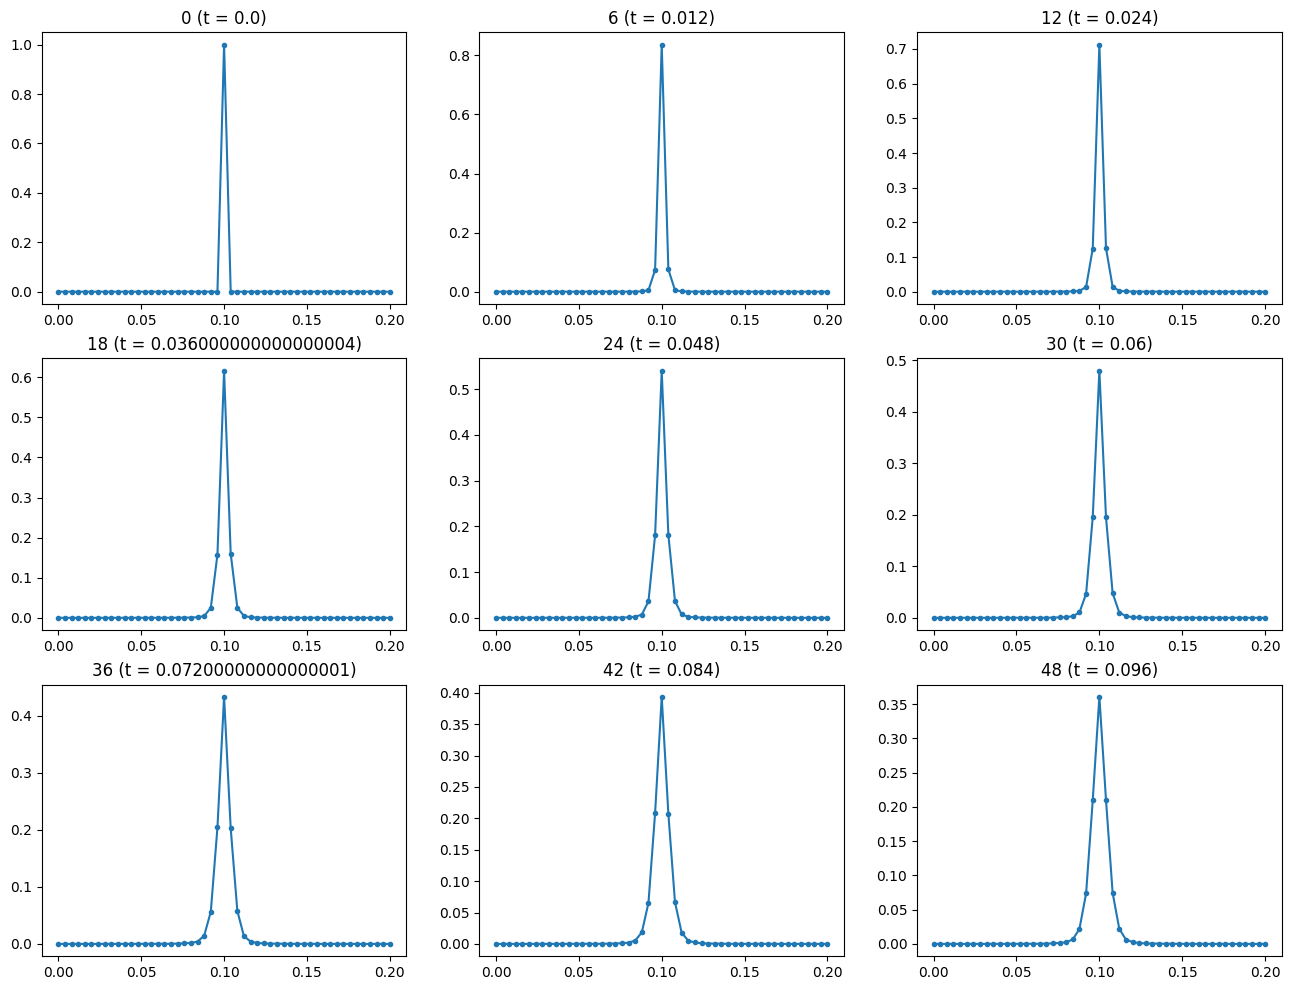

In [14]:
count = 10**5
mc = MonteCarlo(P.L, P.R, P.T, P.alpha, P.beta, 0.0005, P.h, P.tau, P.psi)
mc.solve(count)
mc.draw(3, count)

In [18]:
def draw_compair(rows, count, mfdes, mc):
    res1 = np.array(mfdes.result)
    res2 = np.array(mc.result)
    colums = 3
    all_count = colums * rows
    step = mfdes.k // (all_count - 1)

    fig, ax = plt.subplots(rows, colums, figsize=(16, 4*rows), sharex='none', sharey='none')
    X = np.array([mfdes.h*i for i in range(mfdes.n+1)])

    for kk in range(0, all_count):

        TIME = np.array([mfdes.tau*kk*step for i in range(mfdes.n+1)])

        ax[kk // colums, kk % colums].plot(X, res1[kk*step], '.-')
        ax[kk // colums, kk % colums].plot(X, res2[kk*step] / count * 2.0, '.-')
        ax[kk // colums, kk % colums].set_title(f"{kk*step} (t = {mfdes.tau*kk*step})")

    plt.show()

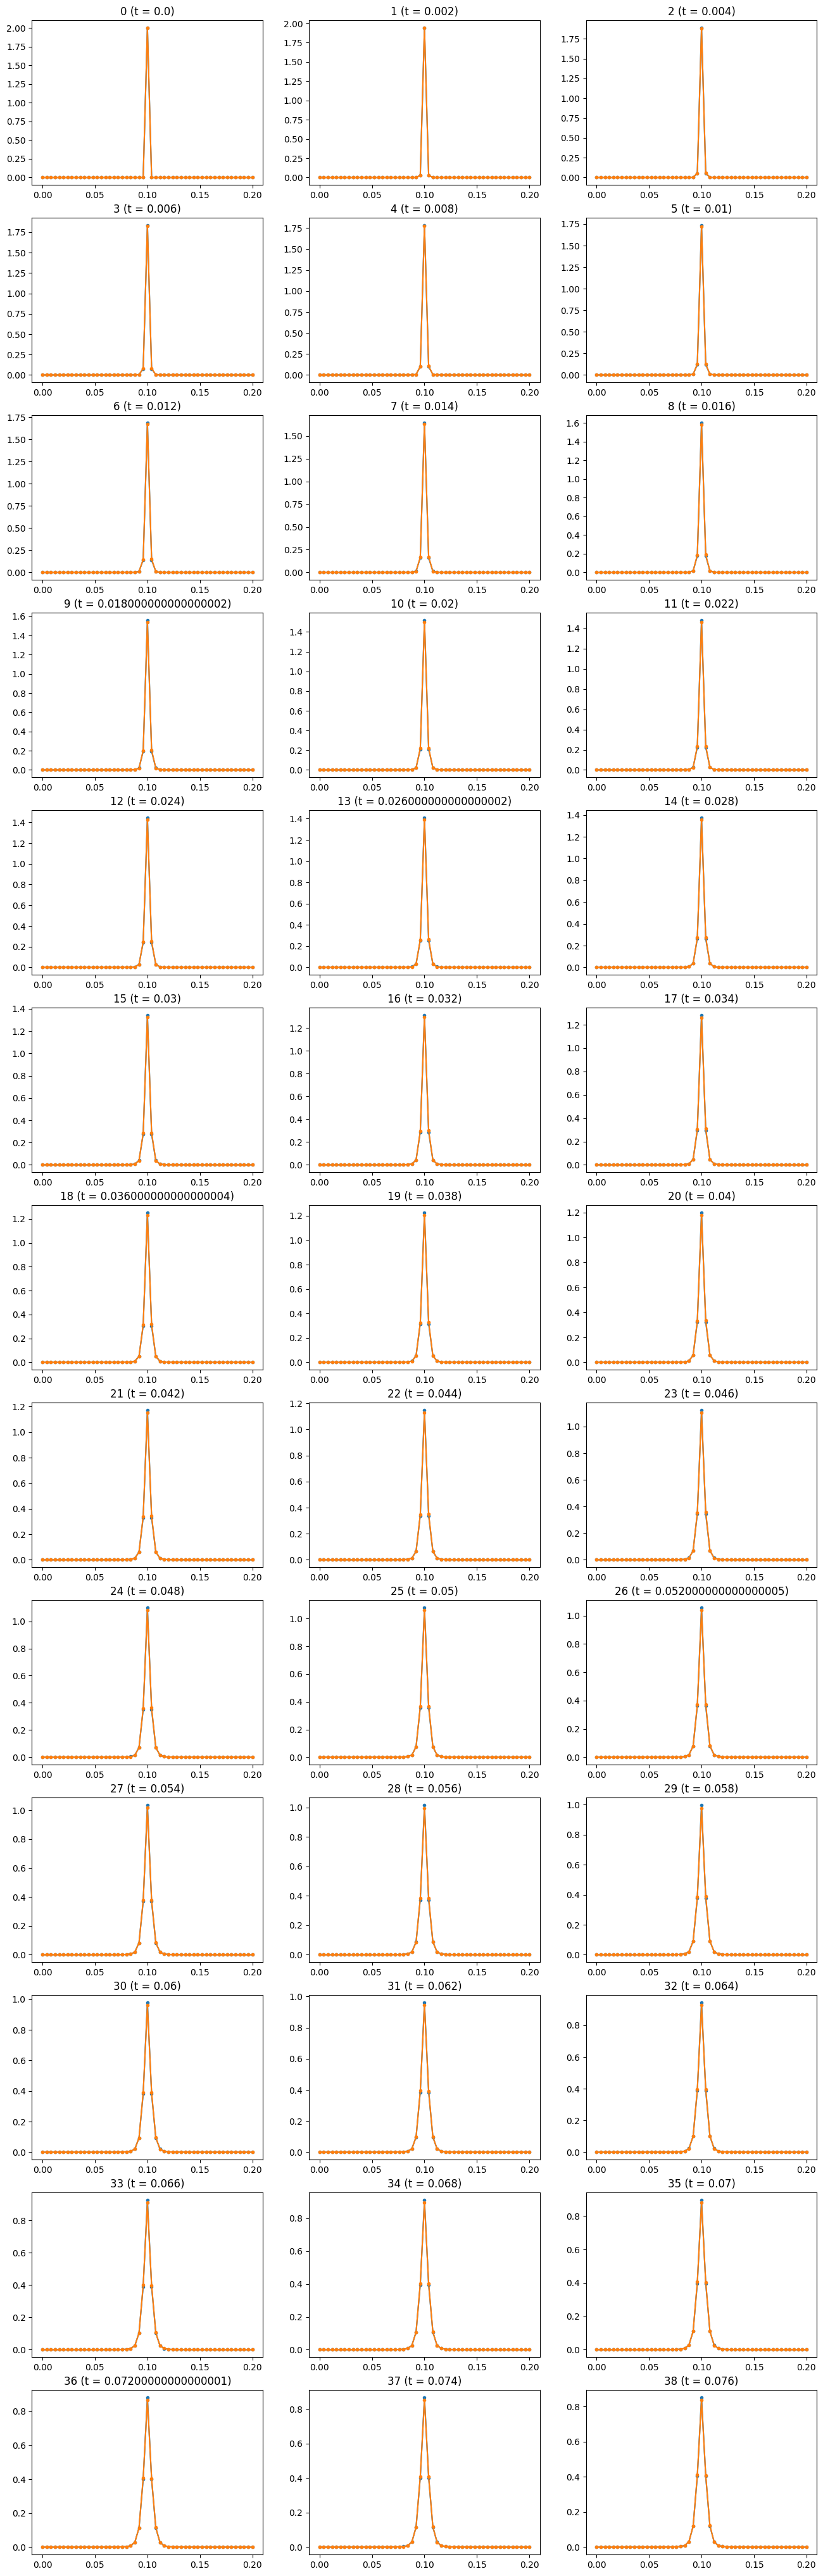

In [20]:
draw_compair(13, count, mfdes, mc)